In [1]:
import jax.numpy as np
from jax import random 
from jax import grad
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

Quick notebook using analytic approximation for the ground roll of an aircraft to determine the necessary operating parameters for our airplane to be able to take off within the 10m bounding box.

For references consult Raymer Conceptual Design p. 673 or Anderson Airplane Performance and Design p. 360

The idea of using an autodifferentiation library is to determine the sensitivity of our solution to small changes in our operating assumptions. 

We will further extend this sensitivity analysis with Monte Carlo simulations to determine the likelihood of making the 10m bounding box.

In [2]:
def KT(P, Vlo, W, mur):
    T = P / (0.7 * Vlo)
    return T / W - mur

def KA(W, S, K, mur, cd0, CL):
    rho = 1.23
    return -rho  / (2 * W / S) * (K * CL**2 - mur * CL + cd0)

def G(b, h):
    n = (16 * h / b)**2 
    return n / (1 + n)

def K(k, G, e, AR):
    return G / (np.pi * e * AR) + k

def sg(KA, KT, Vlo):
    return 1 / (2 * 9.81 * KA) * np.log(1 + KA / KT * Vlo**2)

def Vlo(S, W, CL):
    rho = 1.23
    return np.sqrt(2 * W / (rho * S * CL)) 

def S(b, AR):
    return b**2 / AR

def W(m):
    return 9.81 * m

def calc_sg(CL, cd0, P, m, mur, b, AR, h, e, k):
    _G = G(b, h)
    _S = S(b, AR)
    _W = W(m)
    _Vlo = Vlo(_S, _W, CL)
    _KT = KT(P, _Vlo, _W, mur)
    _K = K(k, _G, e, AR)
    _KA = KA(_W, _S, _K, mur, cd0, CL)
    return sg(_KA, _KT, _Vlo)

def sg_vec(x):
    CL, cd0, P, m, mur, b, AR, h, e, k = x
    return calc_sg(CL, cd0, P, m, mur, b, AR, h, e, k)

def Vlo_vec(x):
    CL, cd0, P, m, mur, b, AR, h, e, k = x
    return Vlo(S(b, AR), W(m), CL)
    

In [11]:
1300 * 0.8 / (0.7 * 12)

123.80952380952382

In [3]:
CL = 0.8
cd0 = 0.08
P = 900 * 0.8 * 0.4
m = 7.7
mur = 0.08
b = 3.5
AR = 8.167
h = 0.5
e = 0.9
k = 0.01
x0 = np.array([CL, cd0, P, 10, mur, b, 8, h, e, k])
x = np.array([CL, cd0, P, m, mur, b, AR, h, e, k])
x_P = np.array([CL, cd0, P*1.5, m+0.5, mur, b, AR, h, e, k])
# absolute confidence intervals
CI95 = np.array([0.1, 0.02, 100, 0.5, 0.02, 0.1, 0.1, 0.2, 0.07, 0.008])
CI95_tight = np.array([0.05, 0.02, 50, 0.25, 0.02, 0.05, 0.1, 0.2, 0.07, 0.008])
sg_vec(x_P)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Array(8.877228, dtype=float32)

In [4]:
Vlo(S(b, AR), W(m), 1.2)

Array(8.260663, dtype=float32, weak_type=True)

In [5]:
# mass calculations
1.5 + 3.36 + 1 + 0.6 + 2 * (0.214 + 0.144 + 0.054) + (0.251 + 0.144 + 0.054)

7.732999999999999

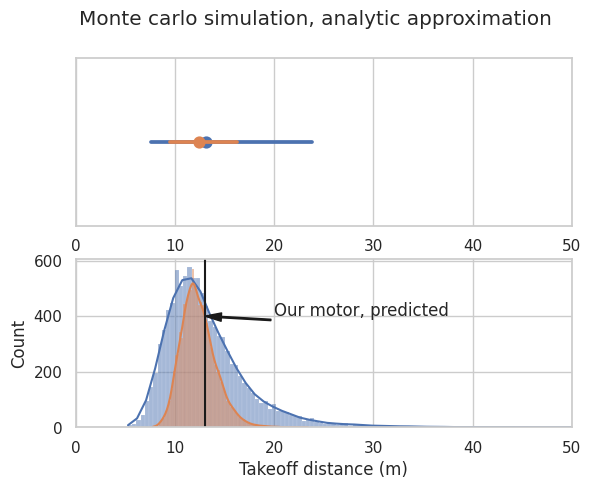

In [20]:
(0.214 + 0.144 + 0.054 )*2 + 0.251 + 0.144 + 0.054

# Monte Carlo simulations with the CI95

# we do this because randomness isn't pure
key = random.key(0)

def random_vector(key, x, CI95, n_samples):
    shape = (n_samples, len(x))
    std_dev = CI95 / 1.96
    return (std_dev * random.normal(key, shape=shape) + x).T

X = random_vector(key, x, CI95, 10000)
key, subkey = random.split(key)
X_tight = random_vector(subkey, x, CI95_tight, 10000)

monte_carlo = sg_vec(X)
monte_carlo_tight = sg_vec(X_tight)

sns.set_theme(style="whitegrid")

ax0 = plt.subplot(211)
sns.pointplot(x=monte_carlo, errorbar=("pi", 95), ax=ax0)
sns.pointplot(x=monte_carlo_tight, errorbar=("pi", 95), ax=ax0)
ax1 = plt.subplot(212, sharex=ax0)
sns.histplot(x=monte_carlo, kde=True, ax=ax1)
sns.histplot(x=monte_carlo_tight, kde=True, ax=ax1)
plt.xlabel("Takeoff distance (m)")
plt.xlim(0, 50)
plt.gcf().suptitle("Monte carlo simulation, analytic approximation")
arrowprops = dict(
    color="k",
    width=1,
    headwidth=6
)
plt.annotate("Our motor, predicted", xy=(13,400), xytext=(20,400), arrowprops=arrowprops)
plt.axvline(13, color="k")

In [7]:
# calculate W/S
print("W/S [Pa]", 8.2 * 9.81 / 1.5)
# calculate Vstall
print("Vstall [m/s]", Vlo_vec(x_P))

W/S [Pa] 53.62799999999999
Vstall [m/s] 10.440519


In [8]:
print(len(monte_carlo[monte_carlo > 10]))
print(len(monte_carlo_tight[monte_carlo_tight > 10]))

2918
1310


CL: 0.80 +/- 0.05
cd0: 0.08 +/- 0.02
P: 432.00 +/- 50.00
m: 8.20 +/- 0.25
mur: 0.08 +/- 0.02
b: 3.50 +/- 0.05
AR: 8.17 +/- 0.10
h: 0.50 +/- 0.20
e: 0.90 +/- 0.07
k: 0.01 +/- 0.01
Takeoff distance 8.877228 m


<Axes: xlabel='Theoretical effect (m)', ylabel='name'>

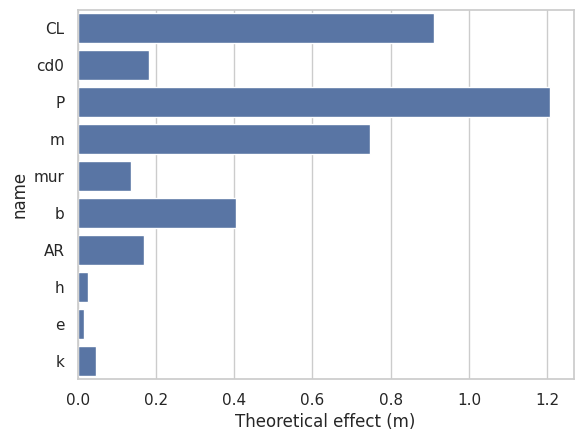

In [9]:

names = ["CL", "cd0", "P", "m", "mur", "b", "AR", "h", "e", "k"]
ds = grad(sg_vec)(x_P)
sensitivities = {"name": names, "Theoretical effect (m)": np.abs(ds * CI95_tight)}

print("\n".join([f"{name}: {val:.2f} +/- {ci95:.2f}"  for name, val, ci95 in zip(names, x_P, CI95_tight)]))

print("Takeoff distance", sg_vec(x_P), "m")

sns.barplot(sensitivities, y="name", x="Theoretical effect (m)")

In [10]:
-10 / grad(S)(float(b), float(AR)) + 2.5 / grad(S, 1)(float(b), float(AR) )

Array(-25.279364, dtype=float32, weak_type=True)

In [10]:
Vlo_vec(x)
grad(Vlo_vec)(x)

Array([-6.323252  ,  0.        ,  0.        ,  0.6569614 ,  0.        ,
       -2.8906295 ,  0.61939543,  0.        ,  0.        ,  0.        ],      dtype=float32)

In [11]:
calc_sg(CL, cd0, P, m - 3, mur, b, AR, h, e, k)
# Vlo(S(b, AR), W(m-3), CL)

Array(3.121619, dtype=float32, weak_type=True)

In [12]:
P / (0.7 * 11)

37.40259740259741

In [13]:
def get_suvat(m, P, v):
    F = P/(0.7 * v)
    a = F / m
    return v**2 / (2 * a)

In [14]:
get_suvat(m, P, 9.6)

8.27904

In [15]:
grad(sg,0)(3.8e-4, 0.25, 13.0)

Array(-8560.633, dtype=float32, weak_type=True)